In [1]:
import json
from pathlib import Path

import pandas as pd

questions = pd.read_csv(Path("qs.txt"))


def get_row(line: str) -> dict | None:
    # print(idx, end=" ")
    line = line.strip()

    if len(line) == 0:
        return None

    # Parse JSON
    record = json.loads(line)

    annotator_name = record["metadata"].get("annotator_id", None)
    example_id = record.get("example_idx", None)
    llm_id = record.get("setup_id", None)

    flags = record.get("flags", [])
    flag_dict = {flag["label"]: flag["value"] for flag in flags}

    options = record.get("options", [])
    option_dict = {}
    for opt in options:
        option_label = opt.get("label", "")
        option_value = opt.get("value", "")
        option_dict[option_label] = option_value

    annotations = record.get("annotations", [])
    anns: dict[int, int] = {}
    for ann in annotations:
        ann_type = ann.get("type", None)

        if ann_type is None:
            continue

        anns[ann_type] = anns.get(ann_type, 0) + 1

    return {
        "annotator": annotator_name,
        "question_id": example_id,
        "llm": llm_id,

        "incorrect": anns.get(0, 0),
        "not_checkable": anns.get(1, 0),
        "misleading": anns.get(2, 0),
        "other": anns.get(3, 0),

        "accurate": flag_dict.get("The text 100% accurate and does not contain any errors.", None),
        "missing": flag_dict.get("The text is missing or incomplete.", None),
        "off_topic": flag_dict.get("The text is severely off-topic (seems completely unrelated to the data).", None),
        "clearness": option_dict.get("Answer Clearness (if it is understandable)", None),
        "length": option_dict.get(
            "Answer length (if it was too short to be 100% clear or too long and made you lose time)", None),
        "usefulness": option_dict.get("Answer Usefulness", None),
        "like": option_dict.get("Do you like the answer? (Personal standpoint)", None),
    }


def load_evals(folder="human"):
    data = []

    for file in Path("eval_data").joinpath(folder).glob("*.jsonl"):
        print(file)
        with file.open("r") as f:
            line: str
            for idx, line in enumerate(f):
                row = get_row(line)

                if row is not None:
                    data.append(row)

    return data


records = load_evals()
records_o3 = load_evals("gpt_o3_mini")
records_45 = load_evals("gpt_45")

df = pd.DataFrame(records)
df

eval_data/human/24-6-1741550780.jsonl
eval_data/human/17-4-1741523151.jsonl
eval_data/human/29-7-1741542713.jsonl
eval_data/human/16-4-1741523452.jsonl
eval_data/human/1-0-1741517242.jsonl
eval_data/human/8-2-1741438356.jsonl
eval_data/human/18-4-1741523930.jsonl
eval_data/human/14-3-1741513492.jsonl
eval_data/human/33-8-1741553328.jsonl
eval_data/human/20-5-1741529037.jsonl
eval_data/human/30-7-1741545683.jsonl
eval_data/human/28-7-1741546354.jsonl
eval_data/human/5-1-1741441099.jsonl
eval_data/human/34-8-1741547467.jsonl
eval_data/human/12-3-1741527321.jsonl
eval_data/human/36-9-1741553875.jsonl
eval_data/human/6-1-1741464487.jsonl
eval_data/human/22-5-1741531276.jsonl
eval_data/human/2-0-1741442474.jsonl
eval_data/human/38-9-1741555034.jsonl
eval_data/human/32-8-1741553700.jsonl
eval_data/human/21-5-1741529711.jsonl
eval_data/human/25-6-1741542308.jsonl
eval_data/human/9-2-1741473549.jsonl
eval_data/human/13-3-1741474470.jsonl
eval_data/human/0-0-1741460899.jsonl
eval_data/human/37-

,annotator,question_id,llm,incorrect,not_checkable,misleading,other,accurate,missing,off_topic,clearness,length,usefulness,like
0,stefa20,1,gpt-o3-mini,0,0,0,0,True,False,False,Completely clear,Long enough,Useful,Yes
1,stefa20,3,gemma2-9b,1,0,0,0,False,False,False,Mostly clear,Long enough,Neither useful nor useless,Yes
2,stefa20,6,gpt-4o,0,0,0,0,True,False,False,Completely clear,Long enough,Useful,Yes
3,stefa20,8,deepseek-r1-8b,0,0,0,0,True,False,False,Completely clear,Long enough,Useful,Yes
4,stefa20,7,deepseek-r1-8b,0,0,0,1,True,False,False,Completely clear,Long enough,Useful,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,stefa,5,gemma2-9b,0,0,0,0,True,False,False,Completely clear,Long enough,Useful,Yes
746,stefa,10,gpt-4o,0,0,0,0,True,False,False,Completely clear,Long enough,Useful,Yes
747,stefa,6,gpt-o3-mini,0,0,0,0,True,False,False,Completely clear,Long enough,Useful,Yes
748,stefa,2,deepseek-r1-8b,0,0,0,2,True,False,False,Completely clear,Too long,Useful,Yes


In [2]:
# Define aggregation functions:
aggregations = {
    # For error counts, we sum over annotators.
    "incorrect": "sum",
    "not_checkable": "sum",
    "misleading": "sum",
    "other": "sum",
    # For flag-type responses (booleans), compute the mean (proportion of True)
    "accurate": "mean",
    "missing": "mean",
    "off_topic": "mean",
    # For categorical options, we compute the mode (most frequent value).
    "clearness": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    "length": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    "usefulness": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    "like": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
}

# Group by question and LLM and apply the aggregations.
aggregated = df.groupby(["question_id", "llm"]).agg(aggregations).reset_index()

print("Aggregated metrics per question and LLM:")
aggregated

Aggregated metrics per question and LLM:


,question_id,llm,incorrect,not_checkable,misleading,other,accurate,missing,off_topic,clearness,length,usefulness,like
0,0,deepseek-r1-8b,3,0,7,0,0.3,0.0,0.0,Mostly clear,Long enough,Neither useful nor useless,No
1,0,gemma2-9b,0,0,0,1,0.9,0.1,0.0,Completely clear,Too short,Useful,No
2,0,gpt-4o,0,0,0,1,0.9,0.0,0.0,Completely clear,Long enough,Useful,Yes
3,0,gpt-o3-mini,0,0,0,0,1.0,0.0,0.0,Completely clear,Long enough,Useful,Yes
4,0,llama3-1-8b,0,0,0,0,0.9,0.0,0.0,Completely clear,Too short,Useful,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,14,deepseek-r1-8b,0,0,0,1,1.0,0.0,0.0,Completely clear,Long enough,Useful,Yes
71,14,gemma2-9b,0,0,0,2,0.9,0.0,0.0,Completely clear,Long enough,Useful,Yes
72,14,gpt-4o,0,0,0,0,1.0,0.0,0.0,Completely clear,Long enough,Useful,Yes
73,14,gpt-o3-mini,0,0,0,0,1.0,0.0,0.0,Completely clear,Long enough,Useful,Yes


In [3]:
group_llm = df.groupby("llm").agg(aggregations).reset_index()

error_columns = ["incorrect", "not_checkable", "misleading", "other"]
combined_errors = df.groupby("llm")[error_columns].sum()
combined_errors["total"] = combined_errors.sum(axis=1)

group_llm

,llm,incorrect,not_checkable,misleading,other,accurate,missing,off_topic,clearness,length,usefulness,like
0,deepseek-r1-8b,19,11,15,80,0.700000,0.093333,0.000000,Completely clear,Long enough,Useful,Yes
1,gemma2-9b,25,0,10,11,0.660000,0.273333,0.020000,Completely clear,Too short,Useful,No
2,gpt-4o,22,15,3,14,0.900000,0.046667,0.013333,Completely clear,Long enough,Useful,Yes
3,gpt-o3-mini,0,0,2,26,0.986667,0.006667,0.000000,Completely clear,Long enough,Useful,Yes
4,llama3-1-8b,44,1,10,46,0.713333,0.106667,0.020000,Completely clear,Long enough,Useful,Yes


In [4]:
combined_errors / 15 * 10

,incorrect,not_checkable,misleading,other,total
llm,,,,,
deepseek-r1-8b,12.666667,7.333333,10.000000,53.333333,83.333333
gemma2-9b,16.666667,0.000000,6.666667,7.333333,30.666667
gpt-4o,14.666667,10.000000,2.000000,9.333333,36.000000
gpt-o3-mini,0.000000,0.000000,1.333333,17.333333,18.666667
llama3-1-8b,29.333333,0.666667,6.666667,30.666667,67.333333


In [5]:
# Group by LLM and count questions that have at least one occurrence of each error type
error_columns = ["incorrect", "not_checkable", "misleading", "other"]

# Create boolean masks for each error type (True if count > 0)
error_masks = {col: (aggregated[col] > 0) for col in error_columns}

# Count questions with each type of error per LLM
error_counts = {}
error_percentages = {}

for error_type in error_columns:
    # Count questions that have this error type
    counts = aggregated[error_masks[error_type]].groupby("llm").size()
    error_counts[error_type] = counts

    # Calculate percentage
    total_questions = aggregated.groupby("llm").size()
    error_percentages[error_type] = (counts / total_questions * 100).round(2)

# Convert results to DataFrames for better display
error_counts_df = pd.DataFrame(error_counts).fillna(0)
error_percentages_df = pd.DataFrame(error_percentages).fillna(0)

print("\nNumber of questions with each error type per LLM:")
error_counts_df


Number of questions with each error type per LLM:


,incorrect,not_checkable,misleading,other
llm,,,,
deepseek-r1-8b,3.0,1.0,4,10
gemma2-9b,4.0,0.0,5,3
gpt-4o,3.0,2.0,3,6
gpt-o3-mini,0.0,0.0,2,3
llama3-1-8b,5.0,1.0,4,7


In [6]:
print("\nPercentage of questions with each error type per LLM:")
error_percentages_df


Percentage of questions with each error type per LLM:


,incorrect,not_checkable,misleading,other
llm,,,,
deepseek-r1-8b,20.00,6.67,26.67,66.67
gemma2-9b,26.67,0.00,33.33,20.00
gpt-4o,20.00,13.33,20.00,40.00
gpt-o3-mini,0.00,0.00,13.33,20.00
llama3-1-8b,33.33,6.67,26.67,46.67


In [7]:
# --- 2. Distribution of categorical responses per LLM ---

# For example, you might want to see how the "clearness" ratings are distributed across LLMs.
llm_clearness_distribution = df.groupby("llm")["clearness"].value_counts().unstack(fill_value=0)
llm_length_distribution = df.groupby("llm")["length"].value_counts().unstack(fill_value=0)
llm_usefulness_distribution = df.groupby("llm")["usefulness"].value_counts().unstack(fill_value=0)
llm_like_distribution = df.groupby("llm")["like"].value_counts().unstack(fill_value=0)

In [8]:
print("\nClearness distribution per LLM:")
llm_clearness_distribution / 150 * 100


Clearness distribution per LLM:


clearness,Completely clear,Mostly clear,Unclear
llm,,,
deepseek-r1-8b,69.333333,30.000000,0.666667
gemma2-9b,56.000000,28.000000,16.000000
gpt-4o,86.000000,8.666667,5.333333
gpt-o3-mini,92.666667,7.333333,0.000000
llama3-1-8b,63.333333,19.333333,17.333333


In [9]:
print("\nLength distribution per LLM:")
llm_length_distribution / 150 * 100


Length distribution per LLM:


length,Long enough,Too long,Too short
llm,,,
deepseek-r1-8b,71.333333,24.666667,4.000000
gemma2-9b,49.333333,0.000000,50.666667
gpt-4o,89.333333,8.666667,2.000000
gpt-o3-mini,96.000000,2.000000,2.000000
llama3-1-8b,78.000000,8.666667,13.333333


In [10]:
print("\nUsefulness distribution per LLM:")
llm_usefulness_distribution / 150 * 100


Usefulness distribution per LLM:


usefulness,Neither useful nor useless,Useful,Useless
llm,,,
deepseek-r1-8b,12.666667,82.000000,5.333333
gemma2-9b,17.333333,58.666667,24.000000
gpt-4o,4.666667,90.000000,5.333333
gpt-o3-mini,2.000000,98.000000,0.000000
llama3-1-8b,12.000000,68.000000,20.000000


In [11]:
print("\nLike distribution per LLM:")
llm_like_distribution / 150 * 100


Like distribution per LLM:


like,No,Yes
llm,,
deepseek-r1-8b,32.000000,68.000000
gemma2-9b,63.333333,36.666667
gpt-4o,13.333333,86.666667
gpt-o3-mini,4.666667,95.333333
llama3-1-8b,42.000000,58.000000


In [25]:
# accurate, missing, off topic distribution:
group_llm[["llm", "accurate", "missing", "off_topic"]]

,llm,accurate,missing,off_topic
0,deepseek-r1-8bdeepseek-r1-8bdeepseek-r1-8bdeep...,70.000000,9.333333,0.000000
1,gemma2-9bgemma2-9bgemma2-9bgemma2-9bgemma2-9bg...,66.000000,27.333333,2.000000
2,gpt-4ogpt-4ogpt-4ogpt-4ogpt-4ogpt-4ogpt-4ogpt-...,90.000000,4.666667,1.333333
3,gpt-o3-minigpt-o3-minigpt-o3-minigpt-o3-minigp...,98.666667,0.666667,0.000000
4,llama3-1-8bllama3-1-8bllama3-1-8bllama3-1-8bll...,71.333333,10.666667,2.000000


In [12]:
import pandas as pd
import numpy as np


def fleiss_kappa(ratings):
    """
    Compute Fleiss' Kappa for a matrix of shape (N, k),
    where N is number of items, and k is number of categories.
    `ratings[i, j]` = number of annotators who assigned item i to category j.
    """
    N, k = ratings.shape
    n_annotators = np.sum(ratings[0, :])  # total number of annotators per item (assuming each row sums to same value)

    # p_j: proportion of all assignments that were to category j
    p_j = np.sum(ratings, axis=0) / (N * n_annotators)

    # P_i: for each item i, what proportion of agreement there is among annotators
    #     = sum over categories of (count_j^2 - count_j) / (n_annotators * (n_annotators - 1))
    P_i = (np.sum(ratings * ratings, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))

    P_bar = np.mean(P_i)  # average P_i over all items
    P_e = np.sum(p_j * p_j)  # expected agreement if all labels are randomly distributed

    kappa = (P_bar - P_e) / (1 - P_e)
    return kappa


# 1) Convert your annotation data into a "ratings matrix" for a single label
#    For example, let's do "clearness" with categories:
#        "Completely clear", "Mostly clear", "Unclear".
# df = pd.DataFrame([
#     {"item_id": "q1_llmA", "annotator": "ann1", "clearness": "Completely clear"},
#     {"item_id": "q1_llmA", "annotator": "ann2", "clearness": "Unclear"},
#     {"item_id": "q1_llmA", "annotator": "ann3", "clearness": "Mostly clear"},
#     # ... more data for other items
# ])

# 2) Determine the categories for clearness
clearness_categories = ["Completely clear", "Mostly clear", "Unclear"]

# 3) Pivot the DataFrame so we count how many times each item got each category
counts = (df
          .groupby(["question_id", "clearness"])
          .size()
          .unstack(fill_value=0)
          .reindex(columns=clearness_categories, fill_value=0)
          .reset_index(drop=True))  # remove item_id index if you want a raw matrix

ratings_matrix = counts.values  # N x k matrix

# 4) Compute Fleiss’ Kappa
fk = fleiss_kappa(ratings_matrix)
print("Fleiss’ Kappa for 'clearness':", fk)

Fleiss’ Kappa for 'clearness': 0.09598218342370929


In [13]:
df["usefulness"]

0                          Useful
1      Neither useful nor useless
2                          Useful
3                          Useful
4                          Useful
                  ...            
745                        Useful
746                        Useful
747                        Useful
748                        Useful
749                        Useful
Name: usefulness, Length: 750, dtype: object

In [14]:
import pandas as pd


def clearness_to_num(value):
    if value == "Completely clear":
        return 2
    elif value == "Mostly clear":
        return 1
    elif value == "Unclear":
        return -1
    return None


def usefulness_to_num(value):
    if value == "Useful":
        return 2
    elif value == "Neither useful nor useless":
        return 0
    elif value == "Useless":
        return -1
    return None


def like_to_num(value):
    return 1 if value == "Yes" else 0 if value == "No" else None


def accuracy_to_num(value):
    # If accurate == True -> 2, else -> 0
    # (Or some other weighting scheme)
    return 1 if value else 0


def length_to_num(value):
    if value == "Too long":
        return -0.5
    elif value == "Long enough":
        return 1
    elif value == "Too short":
        return -0.5
    return None


df["clearness_num"] = df["clearness"].apply(clearness_to_num)
df["usefulness_num"] = df["usefulness"].apply(usefulness_to_num)
df["like_num"] = df["like"].apply(like_to_num)
df["accuracy_num"] = df["accurate"].apply(accuracy_to_num)
df["missing_num"] = df["missing"].apply(accuracy_to_num)
df["off_topic_num"] = df["off_topic"].apply(accuracy_to_num)
df["length_num"] = df["length"].apply(length_to_num)

df["composite_score"] = (df["accuracy_num"]
                         + df["clearness_num"]
                         + df["usefulness_num"]
                         + df["length_num"]
                         + df["missing_num"]
                         + df["off_topic_num"]
                         + df["like_num"]) / 8

# Average or sum per question-LLM
composite_agg = df.groupby(["question_id", "llm"])["composite_score"].mean().reset_index()
composite_agg

,question_id,llm,composite_score
0,0,deepseek-r1-8b,0.28125
1,0,gemma2-9b,0.51875
2,0,gpt-4o,0.79375
3,0,gpt-o3-mini,0.84375
4,0,llama3-1-8b,0.51875
...,...,...,...
70,14,deepseek-r1-8b,0.83750
71,14,gemma2-9b,0.83750
72,14,gpt-4o,0.87500
73,14,gpt-o3-mini,0.87500


In [15]:
# Average score for each model
composite_agg.groupby("llm")["composite_score"].mean()

llm
deepseek-r1-8b    0.663750
gemma2-9b         0.466667
gpt-4o            0.770833
gpt-o3-mini       0.846667
llama3-1-8b       0.567083
Name: composite_score, dtype: float64

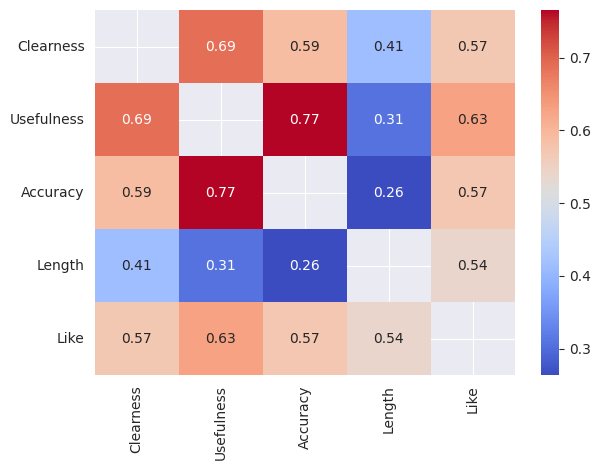

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

pictures_base_path_aiml = Path(f"./diagrams")
pictures_base_path_aiml.mkdir(exist_ok=True)

# Suppose you have numeric columns: clearness_num, usefulness_num, like_num, accuracy_num
corr = df[['clearness_num', 'usefulness_num', 'accuracy_num', "length_num", "like_num"]].corr()
mask = corr == 1

labels = ["Clearness", "Usefulness", "Accuracy", "Length", "Like"]

sns.heatmap(corr, annot=True, cmap='coolwarm', robust=True, mask=mask, xticklabels=labels, yticklabels=labels)
# plt.title("Correlation Matrix of Annotation Metrics")
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels to 90 degrees
plt.yticks(rotation=0, fontsize=10)  # Optional: Keep y-axis labels horizontal
plt.tight_layout()
# plt.savefig(pictures_base_path_aiml / "correlation_metrics.svg", transparent=True)
plt.show()

In [26]:
corr

,clearness_num,usefulness_num,accuracy_num,length_num,like_num
clearness_num,1.000000,0.688515,0.590348,0.412326,0.570397
usefulness_num,0.688515,1.000000,0.765655,0.307345,0.629651
accuracy_num,0.590348,0.765655,1.000000,0.263111,0.571706
length_num,0.412326,0.307345,0.263111,1.000000,0.538854
like_num,0.570397,0.629651,0.571706,0.538854,1.000000


In [17]:
# Average composite score per annotator
annotator_stats = df.groupby("annotator")["composite_score"].agg(['mean', 'std', 'count']).reset_index()
annotator_stats


,annotator,mean,std,count
0,andry,0.6100,0.350910,25
1,angelop,0.7125,0.237993,25
2,dvd,0.6500,0.244070,25
3,elicaito,0.6475,0.336031,25
4,gattolfo,0.6625,0.350316,25
5,jacopo,0.6075,0.283280,25
6,polpiantina,0.7325,0.237664,25
7,sara,0.7100,0.251221,25
8,simov,0.6425,0.239710,25
9,ste,0.7475,0.241712,25


In [18]:
import statsmodels.formula.api as smf

# Example: Predicting composite_score with a random effect for annotators and question_id.
model = smf.mixedlm("composite_score ~ llm", data=df, groups=df["annotator"])
result = model.fit()
print(result.summary())


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: composite_score
No. Observations: 750     Method:             REML           
No. Groups:       30      Scale:              0.0826         
Min. group size:  25      Log-Likelihood:     -146.1055      
Max. group size:  25      Converged:          Yes            
Mean group size:  25.0                                       
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.667    0.025 27.040 0.000  0.618  0.715
llm[T.gemma2-9b]   -0.198    0.033 -5.933 0.000 -0.263 -0.133
llm[T.gpt-4o]       0.102    0.033  3.056 0.002  0.037  0.167
llm[T.gpt-o3-mini]  0.176    0.034  5.187 0.000  0.109  0.242
llm[T.llama3-1-8b] -0.098    0.033 -2.955 0.003 -0.163 -0.033
Group Var           0.002    0.005                           



/home/stefa/IdeaProjects/tesi_tln/venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


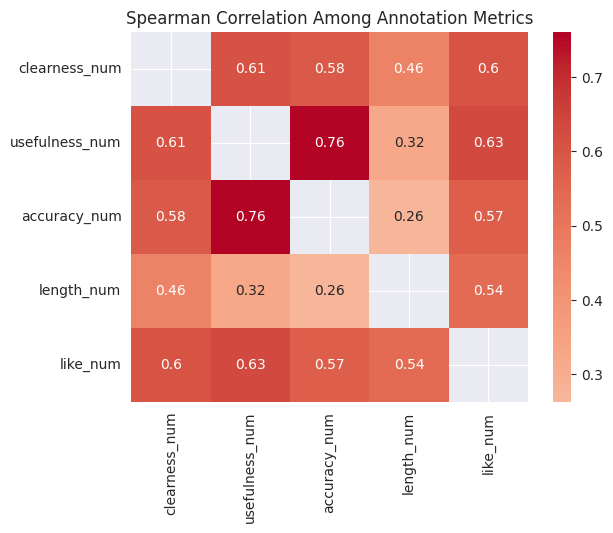

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose df has numeric columns for each metric, e.g.:
#   clearness_num, usefulness_num, length_num, like_num, accurate_num
# (already pre-mapped as discussed).

# Example correlation calculation (Spearman)
corr_matrix = df[['clearness_num', 'usefulness_num', 'accuracy_num', "length_num", "like_num"]].corr(method="spearman")
mask = corr_matrix == 1

# Visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, mask=mask, )
plt.title("Spearman Correlation Among Annotation Metrics")
plt.show()


In [20]:
import statsmodels.api as sm


# X = df[["clearness_num", "usefulness_num", "length_num", "accuracy_num"]]
# y = df["like_num"]

def likelihood(X, y):
    X = sm.add_constant(X)  # adds intercept
    logit_model = sm.Logit(y, X).fit()
    print(logit_model.summary())


likelihood(df[["clearness_num", "usefulness_num", "length_num", "accuracy_num"]], df["like_num"])

Optimization terminated successfully.
         Current function value: 0.309595
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               like_num   No. Observations:                  750
Model:                          Logit   Df Residuals:                      745
Method:                           MLE   Df Model:                            4
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:                  0.5004
Time:                        10:29:44   Log-Likelihood:                -232.20
converged:                       True   LL-Null:                       -464.72
Covariance Type:            nonrobust   LLR p-value:                 2.413e-99
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.7680      0.424     -8.888      0.000      -4.599      -2.937
clearness_num    